In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from modules import *
from astropy.table import Table
import scipy.signal as signal
import scipy.optimize as optimize
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from tqdm import tqdm

plt.style.use('seaborn-v0_8-darkgrid')

TIC = 'TIC 219107776'

cadence_magnifier = 10
cadence = 120

In [4]:
lcs = get_lightcurves(TIC, author = 'SPOC', cadence='short', use_till=5)

SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   219107776      0.0
  1 TESS Sector 15 2019   SPOC     120   219107776      0.0
  2 TESS Sector 16 2019   SPOC     120   219107776      0.0
  3 TESS Sector 17 2019   SPOC     120   219107776      0.0
  4 TESS Sector 18 2019   SPOC     120   219107776      0.0


In [3]:
lc = combine_lightcurves(lcs)
pd.DataFrame({'time' : np.diff(lc.time.btjd) * 86400, 'flux' : lc.flux[:-1]}).to_csv('data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86002 entries, 0 to 86001
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    86002 non-null  float64
 1   flux    74645 non-null  float32
dtypes: float32(1), float64(1)
memory usage: 1008.0 KB
None
Index       132
time     688016
flux     344008
dtype: int64


In [5]:
new_lcs = []

for lc in lcs:
    df = pd.DataFrame({'time': lc.time.jd, 'flux': np.array(lc.flux, dtype='f')}).dropna(inplace=False)
    new_lc = lk.LightCurve(time= df['time'], flux= df['flux'])
    
    new_lc = apply_savgol_filter(new_lc.time.jd, new_lc.flux, want = 'lc', displaygraphs= False, window_length_for_remove=900)
    # new_lc = straight_lines(new_lc, cadence_magnifier= 10)
    new_lc = straight_lines_without_straight_lines(new_lc, cadence_magnifier= 10)

    new_lcs.append(new_lc)
    # new_lc.plot()

Gaps at times: [1696.38854348]
Gaps at times: [1721.58580465]
Gaps at times: [1748.68724642]
Gaps at times: [1773.58173744]
Gaps at times: [1791.10954097 1800.4581543 ]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755448 entries, 0 to 755447
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    755448 non-null  float64
 1   flux    755448 non-null  float64
dtypes: float64(2)
memory usage: 11.5 MB
None
Index        132
time     6043584
flux     6043584
dtype: int64


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

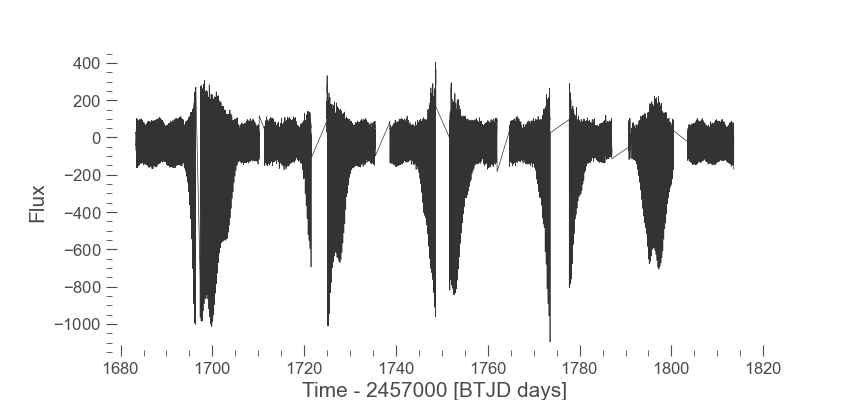

In [14]:
lightcurve = combine_lightcurves(new_lcs)
lightcurve.plot()

In [ ]:
new_lightcurve = straight_lines(lightcurve, cadence_magnifier= 1)
axess = new_lightcurve.plot()
lightcurve.plot(ax= axess, color= 'red')

print(pd.DataFrame({'time': new_lightcurve.time.jd, 'flux': new_lightcurve.flux}).info())
print(pd.DataFrame({'time': lightcurve.time.jd, 'flux': lightcurve.flux}).info())


FINDING THE PERIOD
-------------

The next section here finds the period to be used for O-C calculations as well as for folding.
A gaussian curve is fit on a Periodogram that is obtained from the desired `lightcurve`.

Please click on the desired peak to make the program process data, the peak should be the tallest peak in the entire mess of principle peak.

PS: Clicking on a point draws a gaussian which is selected for the O-C calculations. If you missed_click, just click on the right point afterwards and it will draw a curve in a different color, allowing you to choose another point.

In [7]:
periodogram = lightcurve.to_periodogram(maximum_frequency = 30)

peak_width = 1 / ( (lightcurve.time.btjd[-1] - lightcurve.time.btjd[0]) * 2)
print(peak_width)
max_power = periodogram.max_power.value
optimized_parameters_global = []

colors = ['red', 'green', 'purple', 'orange', 'yellow', 'pink', 'brown', 'magenta', 'cyan']
def color_change():
    c = colors.pop(0)
    colors.append(c)
    yield c

frequencies = periodogram.frequency.value
power = periodogram.power.value
f = np.linspace(frequencies.min(), frequencies.max(), 1000000)
p = spline(frequencies, power, k = 3)(f)

peaks, peakdict = signal.find_peaks(p, height = max_power/10)
peaks_df = pd.DataFrame({'frequencies': f[peaks], 'power': p[peaks], 'peak_index': peaks})

fi = go.FigureWidget([
    go.Scatter(x=f[peaks], y=p[peaks], mode = 'markers', name = 'Peaks', marker = {
        'symbol': 'x',
        'size': 7,
    }),
    go.Scatter(x=frequencies, y=power, mode='lines', name = 'Periodogram', line = dict(color='black')),
], layout = go.Layout(title = 'Periodogram Peaks', xaxis_title = 'Frequency [1/d]', yaxis_title = 'Power'))

scatter = fi.data[0]
fi.layout.hovermode = 'closest'

def update_point(trace, points, selector):
    for i in points.point_inds:
        initial_guess = [peaks_df['power'][i], peaks_df['frequencies'][i], peak_width]
        optimized_parameters, covariance = optimize.curve_fit(gaussian, frequencies, power, p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = gaussian(frequencies, amp, cen, wid)
        initial_gaussian = gaussian(frequencies, *initial_guess)

        fi.add_trace(go.Scatter(x=frequencies, y=fitted_gaussian, mode='lines', name='Fitted Gaussian', line=dict(color=next(color_change()))))
        fi.add_trace(go.Scatter(x=frequencies, y=initial_gaussian, mode='lines', name='Initial Gaussian', line=dict(color=next(color_change()))))
        optimized_parameters_global.append(optimized_parameters)
        print(optimized_parameters_global[-1])
    
scatter.on_click(update_point)
fi


0.00383950301758526


FigureWidget({
    'data': [{'marker': {'size': 7, 'symbol': 'x'},
              'mode': 'markers',
              'name': 'Peaks',
              'type': 'scatter',
              'uid': '46661a53-83cc-4e97-bdc2-0140e5c9640d',
              'x': array([ 4.53373774,  4.57243426,  4.60729112,  4.6407681 ,  4.64979729,
                           4.66101628,  4.68030455,  4.6908336 ,  4.70136265,  4.71105178,
                           4.72269073,  4.73309979,  4.74290891,  4.75208808,  4.76333707,
                           4.77455606,  4.78379523,  4.79351435,  4.80398341,  4.81544238,
                           4.8251615 ,  4.83536058,  4.84573965,  4.87795675,  4.91779316,
                           4.93327177,  4.95315998,  4.96767867,  5.00835501,  9.29643893,
                           9.37308203,  9.41078863,  9.45353478,  9.46406384,  9.48752172,
                           9.49841074,  9.50737994,  9.51583917,  9.5266082 ,  9.53743723,
                           9.54586647,  9.55489

[6.46117982e+01 4.76334350e+00 4.40685883e-03]
[6.46117982e+01 4.76334350e+00 4.40685883e-03]


In [9]:
try:
    fitted_frequency = optimized_parameters_global[-1][1]
    fitted_period = 1/fitted_frequency
except:
    raise ValueError('No peaks clicked yet, please click on a peak to fit a gaussian to it.')

print(f'Fitted Frequency: {fitted_frequency}')
print(f'Fitted Period: {fitted_period}')

Fitted Frequency: 4.763343500735466
Fitted Period: 0.2099365707817626


DIVIDING INTO CHUNKS
----------

Next part of the code divides the lightcurve into chunks and also removes any chunks that have less that 90% of the average number of values.

In [17]:
lightcurve_df = pd.DataFrame({'time': lightcurve.time.btjd, 'flux': np.array(lightcurve.flux, dtype='f')})
curr_initial_time = lightcurve_df['time'].iloc[0]
curr_end_time = curr_initial_time + fitted_period

chunks = []

for i in tqdm(range(2000)):
    if curr_end_time > lightcurve_df['time'].iloc[-1]:
        break
    else:
        chunk = lightcurve_df[(lightcurve_df['time'] >= curr_initial_time) & (lightcurve_df['time'] <= curr_end_time)]
        curr_initial_time = curr_end_time
        curr_end_time = curr_initial_time + fitted_period
        # plt.savefig(f'Chunks/{i}.png')
        if len(chunk) > 0.9 * fitted_period * (86400 / cadence) * cadence_magnifier:
            chunks.append(chunk)
            plt.figure(num = 3, figsize=(10, 5))
            plt.plot(chunk['time'], chunk['flux'], lw=0.5)

            


 31%|███       | 620/2000 [00:01<00:02, 587.09it/s]
